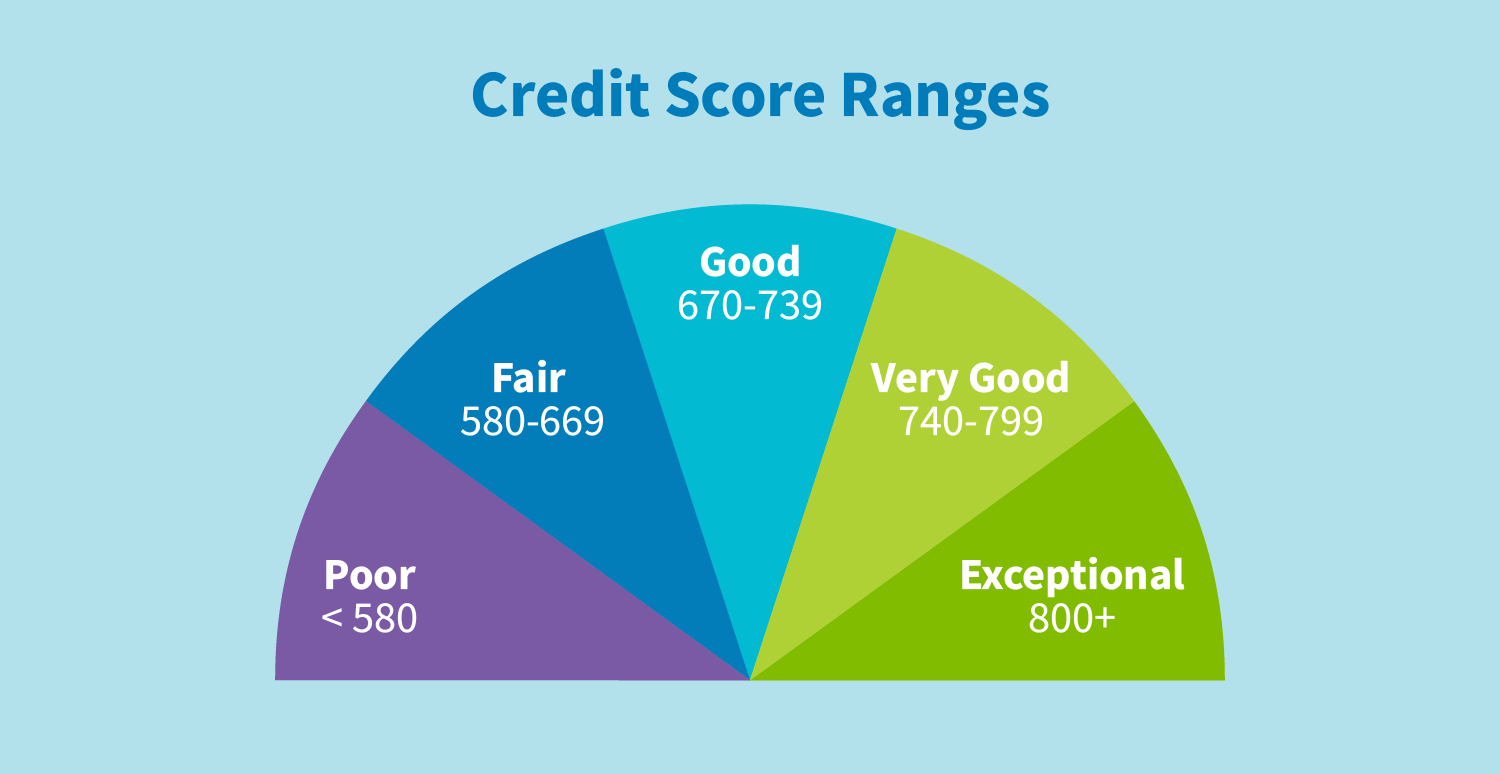

# **<span style="color:#F7B2B0;">Problem Statment</span>**

- In this competition, you’ll apply your machine learning skills to predict credit default. Specifically, you will leverage an industrial scale data set to build a machine learning model that challenges the current model in production.

# **<span style="color:#F7B2B0;">Data</span>**

The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

- D_* = Delinquency variables
- S_* = Spend variables
- P_* = Payment variables
- B_* = Balance variables
- R_* = Risk variables

with the following features being categorical:

`['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']`

Your task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

Note that the negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric

- `train_data.csv` - training data with multiple statement dates per customer_ID
- `train_labels.csv` - target label for each customer_ID
- `test_data.csv` - corresponding test data; your objective is to predict the target label for each customer_ID
- `sample_submission.csv` - a sample submission file in the correct format

In [1]:
!pip -q install optbinning

# **<span style="color:#F7B2B0;">Imports</span>**

In [2]:
import os
import sys
import glob

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
from matplotlib_venn import venn2
import seaborn as sns

from tqdm import tqdm
from itertools import cycle

from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import feature_selection

import lightgbm as lgb
import xgboost as xgb
import catboost as cat

import optbinning

pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

# **<span style="color:#F7B2B0;">Data Loading</span>**

reference: https://www.kaggle.com/competitions/amex-default-prediction/discussion/327400

In [3]:
%%time
train_df = pd.read_feather('../input/amex-default-prediction-feather/train.feather')
test_df = pd.read_feather('../input/amex-default-prediction-feather/test.feather')
train_labels = pd.read_csv("../input/amex-default-prediction/train_labels.csv")
train_df.shape, test_df.shape

CPU times: user 41.2 s, sys: 35.8 s, total: 1min 16s
Wall time: 59.1 s


((5531451, 190), (11363762, 190))

In [4]:
train_df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,NaN,NaN,0.000630,0.080994,0.708984,0.170654,0.006203,0.358643,0.525391,0.255615,NaN,0.063904,0.059418,0.006466,0.148682,1.335938,0.008209,0.001423,0.207275,0.736328,0.096191,NaN,0.023376,0.002768,0.008324,1.001953,0.008301,0.161377,0.148315,0.922852,0.354492,0.151978,0.118103,0.001882,0.158569,0.065735,0.018387,0.063660,0.199585,0.308350,0.016357,0.401611,0.091064,0,1,0.007126,0.007664,NaN,0.652832,0.008522,-1,0.004730,6,0.271973,0.008362,0.515137,0.002644,0.009010,0.004807,0.008339,0.119385,0.004803,0.108276,0.050873,NaN,0.007553,0.080444,0.069092,NaN,0.004326,0.007561,NaN,0.007729,0.000272,0.001575,0.004238,0.001434,NaN,0.002272,0.004059,0.007122,0.002457,0.002310,0.003532,0.506836,0.008034,1.009766,0.084656,0.003820,0.007042,0.000438,0.006451,0.000830,0.005054,NaN,0,0.005722,0.007084,NaN,0.000198,0.008911,NaN,1.0,0.002537,0.005177,0.006626,0.009705,0.007782,0.002449,1.000977,0.002665,0.007481,0.006893,1.503906,1.005859,0.003569,0.008873,0.003948,0.003647,0.004951,0.894043,0.135620,0.911133,0.974609,0.001244,0.766602,1.008789,1.004883,0.893555,NaN,0.669922,0.009972,0.004570,NaN,1.008789,2,NaN,0.004326,NaN,NaN,NaN,1.007812,0.210083,0.676758,0.007874,1,0.238281,0,4,0.232178,0.236206,0,0.702148,0.434326,0.003057,0.686523,0.008743,1,1.002930,1.007812,1.000000,0.006805,NaN,0.002052,0.005970,NaN,0.004345,0.001534,NaN,NaN,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,NaN,NaN,0.002525,0.069397,0.712891,0.113220,0.006207,0.353516,0.521484,0.223389,NaN,0.065247,0.057739,0.001614,0.149780,1.339844,0.008369,0.001984,0.202759,0.720703,0.099792,NaN,0.030594,0.002748,0.002481,1.008789,0.005135,0.140991,0.143555,0.919434,0.326660,0.156250,0.118713,0.001610,0.148438,0.093933,0.013039,0.065491,0.151367,0.265137,0.017685,0.406250,0.086792,0,1,0.002413,0.007149,NaN,0.646973,0.002237,-1,0.003880,6,0.188965,0.004028,0.509277,0.004192,0.007843,0.001283,0.006523,0.140625,0.000094,0.101013,0.040466,NaN,0.004833,0.081421,0.074158,NaN,0.004204,0.005302,NaN,0.001864,0.000978,0.009895,0.007599,0.000509,NaN,0.009811,0.000126,0.005966,0.000395,0.001327,0.007774,0.500977,0.000761,1.009766,0.081848,0.000347,0.007790,0.004311,0.002333,0.009468,0.003754,NaN,0,0.007584,0.006676,NaN,0.001143,0.005905,NaN,1.0,0.008430,0.008980,0.001854,0.009926,0.005989,0.002247,1.006836,0.002508,0.006828,0.002836,1.503906,1.005859,0.000571,0.000391,0.008354,0.008850,0.003180,0.902344,0.136353,0.919922,0.975586,0.004562,0.786133,1.000000,1.003906,0.906738,NaN,0.668457,0.003922,0.004654,NaN,1.002930,2,NaN,0.008705,NaN,NaN,NaN,1.007812,0.184082,0.822266,0.003445,1,0.247192,0,4,0.243530,0.241943,0,0.707031,0.430420,0.001306,0.686523,0.000755,1,1.008789,1.003906,1.008789,0.004406,NaN,0.001034,0.004837,NaN,0.007496,0.004932,NaN,NaN,NaN,NaN,

# **<span style="color:#F7B2B0;">Target Distribution</span>**

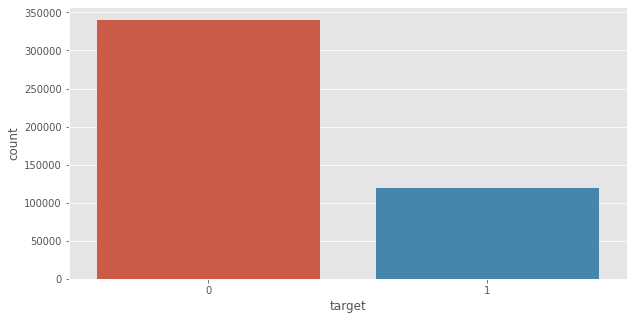

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x=train_labels.target)
plt.show()

- 0 --> Non Default
- 1 --> Default

# **<span style="color:#F7B2B0;">EDA</span>**

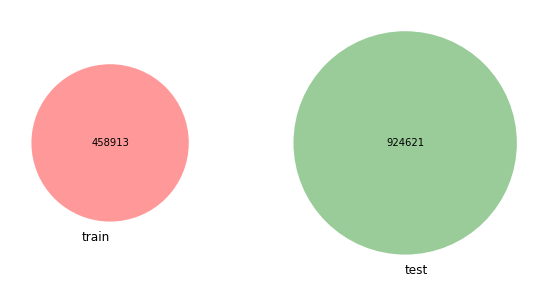

In [6]:
# checking train test customers

fig, ax = plt.subplots(figsize=(10,5))
set1 = set(train_df.customer_ID.unique())
set2 = set(test_df.customer_ID.unique())

venn2([set1, set2], ('train', 'test'))
plt.show()

- we can observe that non of the user intersect in train test data

In [7]:
# s_2 date featue
train_df['S_2'] = pd.to_datetime(train_df['S_2'])
test_df['S_2'] = pd.to_datetime(test_df['S_2'])

train_df['S_2'].min(), train_df['S_2'].max()

(Timestamp('2017-03-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [8]:
test_df['S_2'].min(), test_df['S_2'].max()

(Timestamp('2018-04-01 00:00:00'), Timestamp('2019-10-31 00:00:00'))

- time line also not intersected

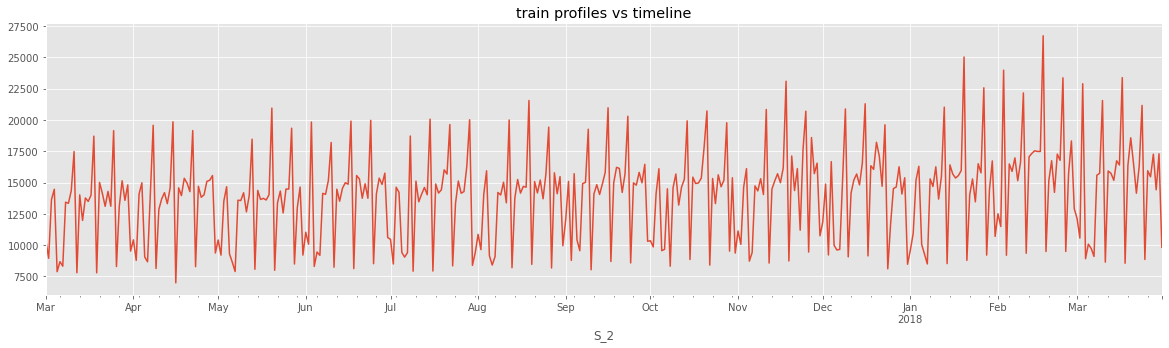

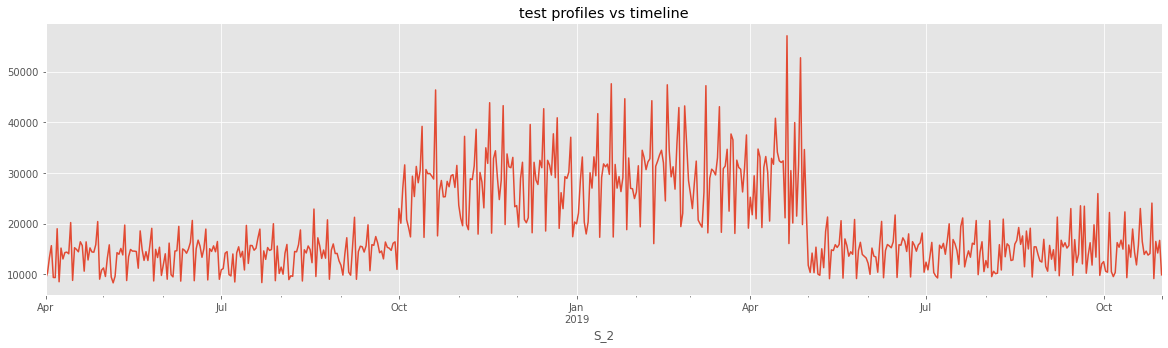

In [9]:
# checking user profiles number of user profiles vs timeline

fig, ax = plt.subplots(figsize=(20,5))
train_df.groupby("S_2")['customer_ID'].count().plot()
plt.title("train profiles vs timeline")
plt.show()

fig, ax = plt.subplots(figsize=(20,5))
test_df.groupby("S_2")['customer_ID'].count().plot()
plt.title("test profiles vs timeline")
plt.show()

- we can observe that train profiles are consistence 
- but test profiles increased between oct to apr

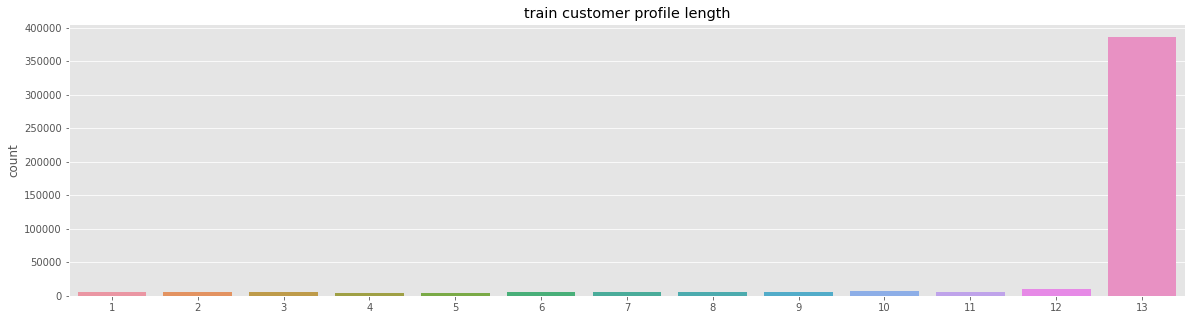

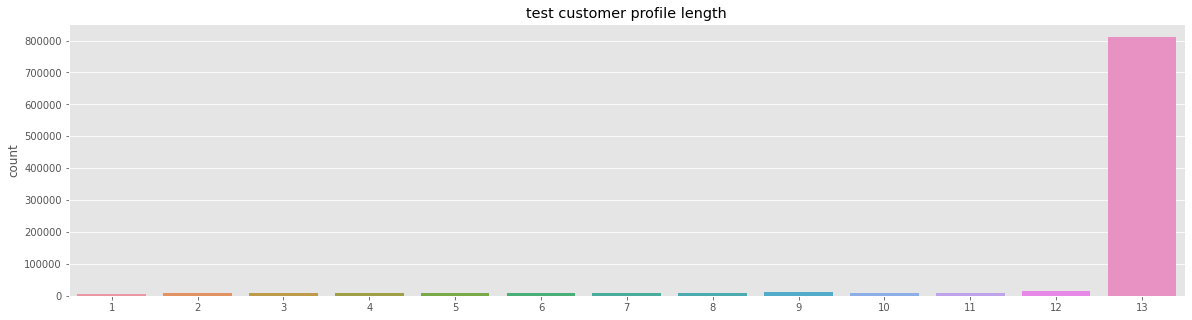

In [10]:
# check each customer profile length

fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(x=train_df.groupby("customer_ID")['customer_ID'].count().values)
plt.title("train customer profile length")
plt.show()

fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(x=test_df.groupby("customer_ID")['customer_ID'].count().values)
plt.title("test customer profile length")
plt.show()

- we can observe that train and test profile lengths are similar distributions

# **<span style="color:#F7B2B0;">Weight of Evidence(WOE)</span>**

The weight of evidence tells the predictive power of an independent variable in relation to the dependent variable. Since it evolved from credit scoring world, it is generally described as a measure of the separation of good and bad customers. "Bad Customers" refers to the customers who defaulted on a loan. and "Good Customers" refers to the customers who paid back loan.

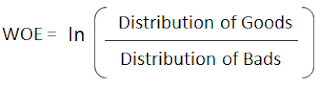

- Distribution of Goods - % of Good Customers in a particular group
- Distribution of Bads - % of Bad Customers in a particular group
- ln - Natural Log

**Steps of Calculating WOE**

1. For a continuous variable, split data into 10 parts (or lesser depending on the distribution).
2. Calculate the number of events and non-events in each group (bin)
3. Calculate the % of events and % of non-events in each group.
4. Calculate WOE by taking natural log of division of % of non-events and % of events

# **<span style="color:#F7B2B0;">Information Value(IV)</span>**

Information value is one of the most useful technique to select important variables in a predictive model. It helps to rank variables on the basis of their importance.

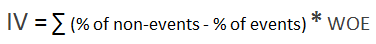

If the IV statistic is:
- Less than 0.02, then the predictor is not useful for modeling (separating the Goods from the Bads)
- 0.02 to 0.1, then the predictor has only a weak relationship to the Goods/Bads odds ratio
- 0.1 to 0.3, then the predictor has a medium strength relationship to the Goods/Bads odds ratio
- 0.3 to 0.5, then the predictor has a strong relationship to the Goods/Bads odds ratio.
- > 0.5, suspicious relationship (Check once)


Reference: https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

# **<span style="color:#F7B2B0;">Feature Selection</span>**

In [11]:
# Training data preparation
# taking latest profile features for each customer

train_df = train_df.groupby("customer_ID").tail(1).reset_index(drop=True)
test_df = test_df.groupby("customer_ID").tail(1).reset_index(drop=True)

In [12]:
# Merge with targets
train_df = train_df.merge(train_labels, on='customer_ID', how='left')

In [13]:
target_col = 'target'
drop_cols = ['customer_ID', 'S_2', target_col]
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
train_cols = [col for col in train_df.columns if col not in drop_cols]

## **<span style="color:#F7B2B0;">Information Value (IV)</span>**

- for selecting features we are calculating IV values for each feature
- thankfully `optbinning` will do for us :) 

In [14]:
iv_score_dict = {}
for col in tqdm(train_cols):
    if col in cat_cols:
        optb = optbinning.OptimalBinning(dtype='categorical')
        optb.fit(train_df[col], train_df['target'])
    else:
        optb = optbinning.OptimalBinning(dtype='numerical')
        optb.fit(train_df[col], train_df['target'])
    binning_table = optb.binning_table
    binning_table.build()
    iv_score_dict[col] = binning_table.iv

iv_score_df = pd.Series(iv_score_dict)
iv_score_df.sort_values(ascending=False, inplace=True)

100%|██████████| 188/188 [01:53<00:00,  1.65it/s]


In [15]:
# top 10 imp iv features
iv_score_df.head(10)

P_2     3.732496
D_48    2.406650
B_18    2.212995
B_7     2.106675
D_75    2.070369
D_61    2.070309
B_23    2.059052
B_10    1.998735
B_9     1.994288
D_44    1.980849
dtype: float64

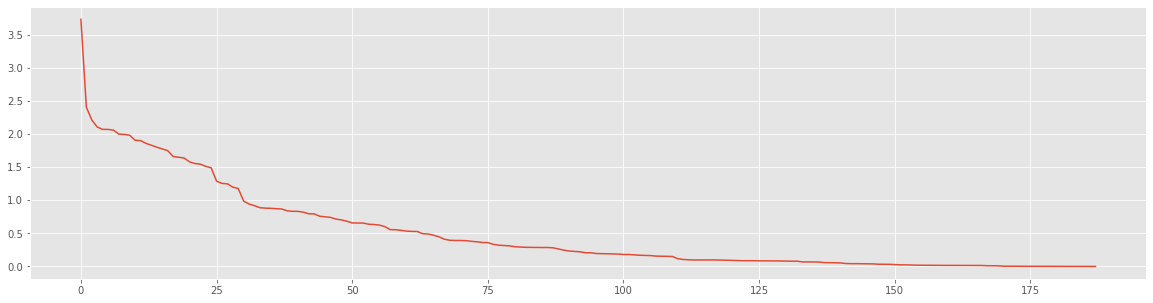

In [16]:
# iv score vs features
fig, ax = plt.subplots(figsize=(20,5))
iv_score_df.reset_index(drop=True).plot()
plt.show()

- we can observe that top 75 features have > 0.5 IV value
- so those top 75 IV value features are strong predictors

## **<span style="color:#F7B2B0;">Weight of Evidence (WOE)</span>**

- i will try to explan woe values and woe plot for one feature

In [17]:
col = 'P_2'
optb = optbinning.OptimalBinning(dtype='numerical')
optb.fit(train_df[col], train_df['target'])
binning_table = optb.binning_table
display(binning_table.build())

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.18)",29733,0.064790,2631,27102,0.911512,-3.383762,0.745582,0.064705
1,"[0.18, 0.32)",34240,0.074611,8586,25654,0.749241,-2.146085,0.409141,0.043147
2,"[0.32, 0.43)",40102,0.087385,15556,24546,0.612089,-1.507621,0.242465,0.027729
3,"[0.43, 0.52)",41474,0.090374,22460,19014,0.458456,-0.884958,0.083160,0.010069
4,"[0.52, 0.58)",28361,0.061800,19500,8861,0.312436,-0.262764,0.004528,0.000564
5,"[0.58, 0.64)",32780,0.071430,26363,6417,0.195760,0.361492,0.008501,0.001057
6,"[0.64, 0.69)",22969,0.050051,20396,2573,0.112021,1.018748,0.039039,0.004679
7,"[0.69, 0.73)",23797,0.051855,22171,1626,0.068328,1.561144,0.080413,0.009141
8,"[0.73, 0.77)",24883,0.054222,23932,951,0.038219,2.173939,0.135583,0.014242
9,"[0.77, 0.82)",33368,0.072711,32634,734,0.021997,2.743082,0.246278,0.023740


- `P_2` is a continuous feature, os we splited into 15 bins 
- each bin have non-event and event counts and rates
- each bin have WOE and IV values 
- for missing values it's created 16th bin

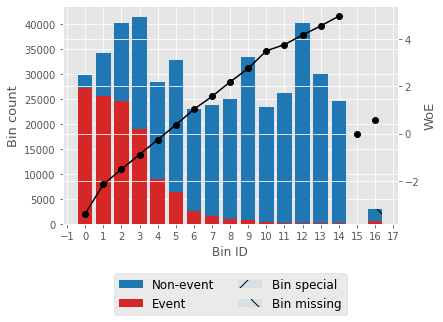

None

In [18]:
display(binning_table.plot(metric="woe"))

- from this woe plot we can observe that while increasing bins the event rate decrease
- you can observe that black doted line that is positively correlated with target

----------------------------------------------------------------------------------------------------
################ Feature Name :  P_2





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.18)",29733,0.064790,2631,27102,0.911512,-3.383762,0.745582,0.064705
1,"[0.18, 0.32)",34240,0.074611,8586,25654,0.749241,-2.146085,0.409141,0.043147
2,"[0.32, 0.43)",40102,0.087385,15556,24546,0.612089,-1.507621,0.242465,0.027729
3,"[0.43, 0.52)",41474,0.090374,22460,19014,0.458456,-0.884958,0.083160,0.010069
4,"[0.52, 0.58)",28361,0.061800,19500,8861,0.312436,-0.262764,0.004528,0.000564
5,"[0.58, 0.64)",32780,0.071430,26363,6417,0.195760,0.361492,0.008501,0.001057
6,"[0.64, 0.69)",22969,0.050051,20396,2573,0.112021,1.018748,0.039039,0.004679
7,"[0.69, 0.73)",23797,0.051855,22171,1626,0.068328,1.561144,0.080413,0.009141
8,"[0.73, 0.77)",24883,0.054222,23932,951,0.038219,2.173939,0.135583,0.014242
9,"[0.77, 0.82)",33368,0.072711,32634,734,0.021997,2.743082,0.246278,0.023740


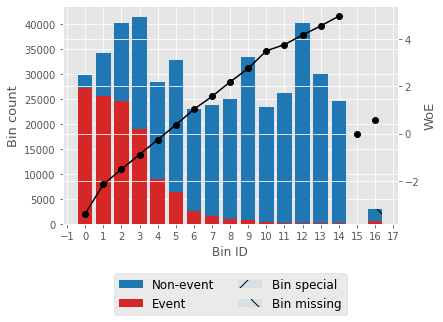

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  D_48





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.03)",40321,0.087862,39743,578,0.014335,3.179097,0.356052,0.031973
1,"[0.03, 0.06)",39897,0.086938,39192,705,0.017671,2.966512,0.324266,0.030154
2,"[0.06, 0.11)",35920,0.078272,35007,913,0.025418,2.595049,0.247185,0.024387
3,"[0.11, 0.17)",36804,0.080198,35137,1667,0.045294,1.996711,0.178286,0.019193
4,"[0.17, 0.28)",38150,0.083131,34542,3608,0.094574,1.207504,0.085981,0.010139
5,"[0.28, 0.44)",40485,0.088219,32488,7997,0.197530,0.350286,0.009889,0.001230
6,"[0.44, 0.54)",23908,0.052097,16308,7600,0.317885,-0.288011,0.004610,0.000574
7,"[0.54, 0.69)",35396,0.077130,20192,15204,0.429540,-0.767791,0.052652,0.006424
8,"[0.69, 0.83)",35742,0.077884,15754,19988,0.559230,-1.289556,0.157179,0.018390
9,"[0.83, 0.90)",24701,0.053825,8613,16088,0.651310,-1.676319,0.184501,0.020693


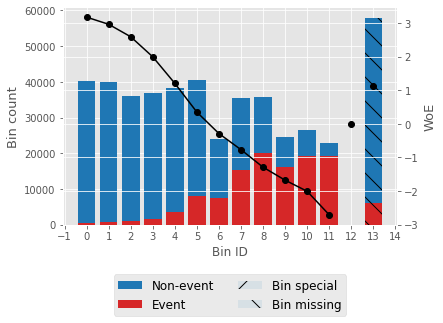

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  B_18





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.07)",35752,0.077906,13231,22521,0.629923,-1.583404,0.238494,0.027042
1,"[0.07, 0.19)",72687,0.158389,28920,43767,0.602130,-1.465865,0.415257,0.047708
2,"[0.19, 0.24)",40086,0.087350,18863,21223,0.529437,-1.169402,0.143997,0.017039
3,"[0.24, 0.33)",22950,0.050009,13625,9325,0.406318,-0.672311,0.025824,0.003169
4,"[0.33, 0.52)",27248,0.059375,20413,6835,0.250844,0.042597,0.000107,0.000013
5,"[0.52, 0.59)",33896,0.073861,28545,5351,0.157865,0.62268,0.024224,0.002980
6,"[0.59, 0.68)",33874,0.073814,30032,3842,0.113420,1.004752,0.056241,0.006749
7,"[0.68, 0.85)",28275,0.061613,25745,2530,0.089478,1.268503,0.069020,0.008092
8,"[0.85, 1.00)",24355,0.053071,23831,524,0.021515,2.765732,0.181609,0.017443
9,"[1.00, 1.00)",31722,0.069124,31045,677,0.021342,2.774003,0.237423,0.022774


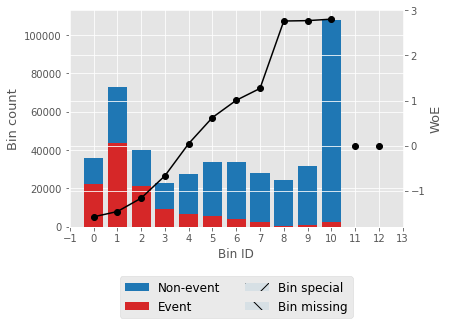

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  B_7





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.03)",117350,0.255713,114931,2419,0.020614,2.809459,0.892258,0.085104
1,"[0.03, 0.03)",24135,0.052592,23564,571,0.023659,2.668568,0.172078,0.016783
2,"[0.03, 0.04)",24001,0.052300,23084,917,0.038207,2.174269,0.130804,0.013740
3,"[0.04, 0.07)",45010,0.098080,41383,3627,0.080582,1.382946,0.126071,0.014612
4,"[0.07, 0.09)",26687,0.058153,22462,4225,0.158317,0.619287,0.018884,0.002323
5,"[0.09, 0.13)",27189,0.059247,20545,6644,0.244364,0.077385,0.000348,0.000044
6,"[0.13, 0.21)",41023,0.089392,27006,14017,0.341686,-0.39573,0.015256,0.001895
7,"[0.21, 0.26)",23421,0.051036,13302,10119,0.432048,-0.778019,0.035822,0.004368
8,"[0.26, 0.35)",29823,0.064986,15239,14584,0.489019,-1.007586,0.078514,0.009419
9,"[0.35, 0.48)",33304,0.072571,14966,18338,0.550625,-1.254713,0.138416,0.016250


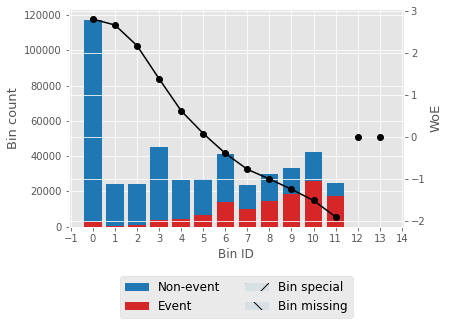

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  D_75





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.00)",33661,0.073349,32897,764,0.022697,2.71105,0.244814,0.023718
1,"[0.00, 0.01)",106859,0.232852,104341,2518,0.023564,2.672681,0.763367,0.074405
2,"[0.01, 0.04)",23965,0.052221,23351,614,0.025621,2.586882,0.164254,0.016226
3,"[0.04, 0.10)",73379,0.159897,64317,9062,0.123496,0.908216,0.102500,0.012390
4,"[0.10, 0.17)",49885,0.108703,36813,13072,0.262043,-0.01614,0.000028,0.000004
5,"[0.17, 0.24)",38977,0.084933,24206,14771,0.378967,-0.557584,0.029624,0.003656
6,"[0.24, 0.33)",31048,0.067656,16630,14418,0.464378,-0.908788,0.065828,0.007957
7,"[0.33, 0.34)",23753,0.051759,11147,12606,0.530712,-1.174521,0.086103,0.010184
8,"[0.34, 0.60)",44191,0.096295,16939,27252,0.616687,-1.527027,0.274150,0.031285
9,"[0.60, inf)",33195,0.072334,9444,23751,0.715499,-1.973764,0.339700,0.036684


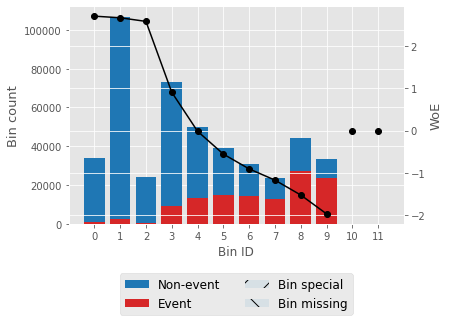

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  D_61





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.06)",68236,0.148690,66962,1274,0.018670,2.910445,0.541856,0.050849
1,"[0.06, 0.10)",35579,0.077529,34654,925,0.025998,2.571856,0.242047,0.023966
2,"[0.10, 0.15)",24268,0.052881,23305,963,0.039682,2.134851,0.128994,0.013625
3,"[0.15, 0.27)",40637,0.088551,37361,3276,0.080616,1.382486,0.113763,0.013186
4,"[0.27, 0.43)",39412,0.085881,32730,6682,0.169542,0.537356,0.021499,0.002655
5,"[0.43, 0.61)",40226,0.087655,29229,10997,0.273380,-0.07398,0.000488,0.000061
6,"[0.61, 0.75)",38414,0.083706,23953,14461,0.376451,-0.54688,0.028036,0.003461
7,"[0.75, 0.85)",37305,0.081290,19356,17949,0.481142,-0.97605,0.091881,0.011050
8,"[0.85, 0.90)",36315,0.079133,14435,21880,0.602506,-1.467436,0.207916,0.023883
9,"[0.90, 0.93)",27055,0.058955,8255,18800,0.694881,-1.874556,0.251075,0.027470


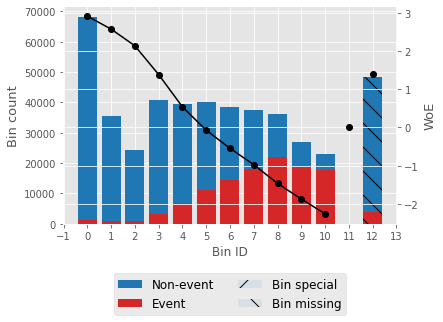

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  B_23





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.02)",127453,0.277728,124656,2797,0.021945,2.745492,0.941719,0.090741
1,"[0.02, 0.03)",36179,0.078836,34869,1310,0.036209,2.230053,0.204063,0.021264
2,"[0.03, 0.05)",44620,0.097230,41241,3379,0.075728,1.450335,0.134636,0.015494
3,"[0.05, 0.08)",30235,0.065884,25345,4890,0.161733,0.593871,0.019820,0.002442
4,"[0.08, 0.11)",27917,0.060833,21086,6831,0.244690,0.07562,0.000341,0.000043
5,"[0.11, 0.18)",35791,0.077991,23702,12089,0.337766,-0.378255,0.012120,0.001506
6,"[0.18, 0.23)",24120,0.052559,13853,10267,0.425663,-0.751952,0.034340,0.004194
7,"[0.23, 0.33)",32374,0.070545,16723,15651,0.483444,-0.985268,0.081322,0.009773
8,"[0.33, 0.43)",27696,0.060351,12532,15164,0.547516,-1.242157,0.112742,0.013251
9,"[0.43, 0.59)",30828,0.067176,12429,18399,0.596828,-1.443782,0.170786,0.019668


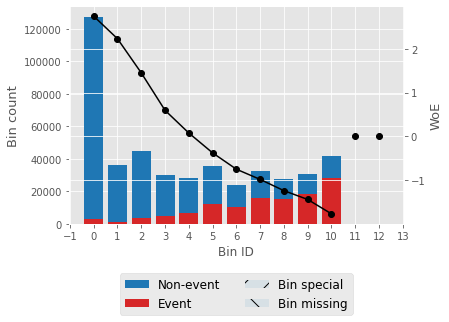

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  B_10





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.01)",44398,0.096746,18053,26345,0.593383,-1.429485,0.241044,0.027802
1,"[0.01, 0.02)",30322,0.066074,13013,17309,0.570840,-1.336796,0.143572,0.016719
2,"[0.02, 0.02)",23563,0.051345,10625,12938,0.549081,-1.248478,0.096929,0.011386
3,"[0.02, 0.03)",37904,0.082595,18791,19113,0.504248,-1.068509,0.112826,0.013468
4,"[0.03, 0.05)",36027,0.078505,20864,15163,0.420879,-0.732352,0.048522,0.005933
5,"[0.05, 0.06)",27439,0.059791,18403,9036,0.329312,-0.340221,0.007461,0.000928
6,"[0.06, 0.11)",37591,0.081913,28764,8827,0.234817,0.129791,0.001336,0.000167
7,"[0.11, 0.19)",33606,0.073230,28846,4760,0.141641,0.750205,0.033581,0.004102
8,"[0.19, 0.28)",38733,0.084402,36251,2482,0.064080,1.629884,0.139692,0.015754
9,"[0.28, inf)",149330,0.325399,146475,2855,0.019119,2.886264,1.173771,0.110581


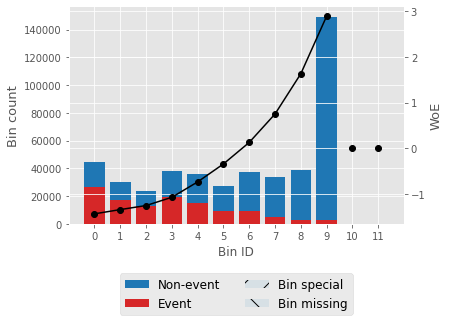

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  B_9





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.00)",91094,0.198499,82588,8506,0.093376,1.221574,0.209210,0.024638
1,"[0.00, 0.01)",33422,0.072829,30336,3086,0.092334,1.233941,0.078023,0.009178
2,"[0.01, 0.01)",76596,0.166907,69652,6944,0.090657,1.254115,0.183565,0.021551
3,"[0.01, 0.03)",24777,0.053991,23809,968,0.039068,2.151068,0.133071,0.014024
4,"[0.03, 0.06)",28198,0.061445,26891,1307,0.046351,1.972539,0.134275,0.014503
5,"[0.06, 0.11)",25110,0.054716,23143,1967,0.078335,1.413664,0.072800,0.008411
6,"[0.11, 0.19)",23903,0.052086,20704,3199,0.133833,0.81597,0.027708,0.003371
7,"[0.19, 0.38)",33975,0.074034,23863,10112,0.297631,-0.192912,0.002880,0.000359
8,"[0.38, 0.57)",36550,0.079645,17750,18800,0.514364,-1.10899,0.117574,0.013987
9,"[0.57, 0.62)",27380,0.059663,8510,18870,0.689189,-1.84785,0.247201,0.027140


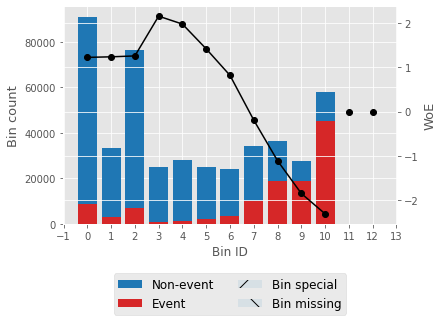

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  D_44





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.07)",271931,0.592555,253648,18283,0.067234,1.578457,0.934409,0.106010
1,"[0.07, 0.13)",37457,0.081621,22961,14496,0.387004,-0.591594,0.032228,0.003971
2,"[0.13, 0.19)",23121,0.050382,14044,9077,0.392587,-0.615067,0.021584,0.002656
3,"[0.19, 0.32)",35285,0.076888,14860,20425,0.578858,-1.369605,0.175573,0.020378
4,"[0.32, 0.38)",23202,0.050559,7624,15578,0.671408,-1.766077,0.191936,0.021291
5,"[0.38, inf)",45622,0.099413,10050,35572,0.779712,-2.315505,0.624736,0.064296
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,22295,0.048582,16898,5397,0.242072,0.089834,0.000383,0.000048
Totals,,458913,1.000000,340085,118828,0.258934,,1.980849,0.218649


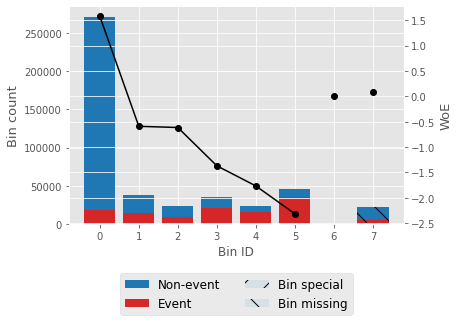

None

In [19]:
# WOE plots for top 10 features
top10_features = iv_score_df[:10].index.values

for col in top10_features:
    print("-"*100)
    print("="*100)
    print("################ Feature Name : ", col)
    print("\n\n")

    if col in cat_cols:
        optb = optbinning.OptimalBinning(dtype='categorical')
        optb.fit(train_df[col], train_df['target'])
    else:
        optb = optbinning.OptimalBinning(dtype='numerical')
        optb.fit(train_df[col], train_df['target'])

    binning_table = optb.binning_table
    display(binning_table.build())
    display(binning_table.plot(metric="woe"))

- selecting features IV values > 0.5

In [20]:
selected_features = iv_score_df[iv_score_df > 0.5].index.values
cat_cols = [col for col in cat_cols if col in selected_features]
train_cols = [col for col in train_df.columns if col in selected_features]

## **<span style="color:#F7B2B0;">Correlation Heatmap</span>**

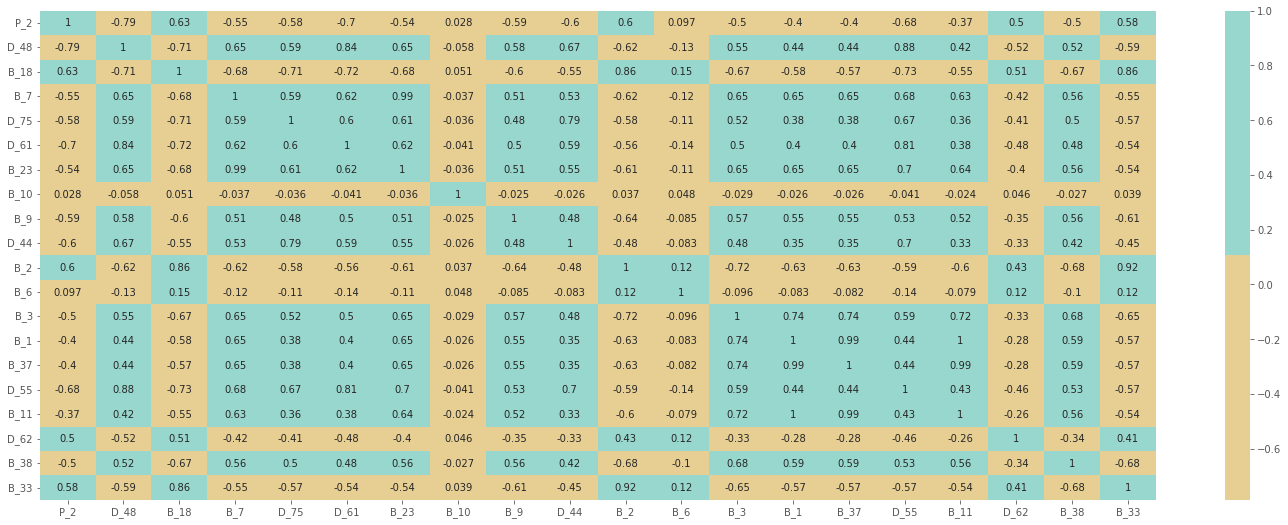

In [21]:
top_cols = [col for col in selected_features[:20] if col in train_cols]
corr_df = train_df[top_cols].corr()
plt.figure(figsize=(25, 9))
sns.heatmap(corr_df,annot=True ,cmap=sns.color_palette("BrBG",2));
plt.show()

In [22]:
def drop_feature_selection(row, col, corr, row_iv, col_iv):
    if row_iv >= col_iv:
        return col
    else:
        return row

In [23]:
cor_matrix = train_df[train_cols].corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool_))
corr_df = upper_tri.stack().reset_index()
corr_df.columns = ['row', 'col', 'corr']
corr_df = corr_df.drop_duplicates()
corr_df = corr_df.sort_values('corr', ascending=False)
corr_df = corr_df.query("corr >= 0.8")
corr_df['row_iv'] = corr_df['row'].map(iv_score_dict)
corr_df['col_iv'] = corr_df['col'].map(iv_score_dict)

corr_df['drop_feature'] = corr_df.apply(lambda x: drop_feature_selection(x['row'], x['col'], x['corr'], x['row_iv'], x['col_iv']), axis=1)

In [24]:
corr_df

,row,col,corr,row_iv,col_iv,drop_feature
1531,D_62,D_77,0.999824,1.660473,1.176555,D_77
144,B_1,B_11,0.995629,1.829305,1.749460,B_11
898,B_7,B_23,0.994963,2.106675,2.059052,B_23
179,B_1,B_37,0.992982,1.829305,1.801300,B_37
1782,D_74,D_75,0.988533,1.554889,2.070369,D_74
1246,B_11,B_37,0.988209,1.749460,1.801300,B_11
1926,S_22,S_24,0.965077,0.795160,0.656930,S_24
1407,D_58,D_75,0.927898,1.512233,2.070369,D_58
1406,D_58,D_74,0.923637,1.512233,1.554889,D_58
233,B_2,B_33,0.918636,1.905190,1.638385,B_33


In [25]:
corr_drop_features = corr_df['drop_feature'].unique().tolist()

# **<span style="color:#F7B2B0;">Modeling</span>**

In [26]:
# train valid split
train_data, valid_data = model_selection.train_test_split(train_df, test_size=0.3, random_state=42, shuffle=True, stratify=train_df['target'])

train_data.shape, valid_data.shape

((321239, 191), (137674, 191))

In [27]:
selected_features = [col for col in selected_features if col not in corr_drop_features]
cat_cols = [col for col in cat_cols if col in selected_features]
train_cols = [col for col in train_df.columns if col in selected_features]

In [28]:
X_train = train_data[train_cols].copy()
y_train = train_data[target_col].copy()

X_valid = valid_data[train_cols].copy()
y_valid = valid_data[target_col].copy()

X_test = test_df[train_cols].copy()

In [29]:
# binning process

# selection_criteria = {
#     "iv": {"min": 0.02, "max": 1},
#     "quality_score": {"min": 0.01}
# }

binning_process = optbinning.BinningProcess(                             
    variable_names=train_cols,
    #selection_criteria=selection_criteria,
    categorical_variables=cat_cols
)

In [30]:
# estimator
estimator = linear_model.LogisticRegression()

In [31]:
# scorecard
scorecard = optbinning.Scorecard(
    binning_process=binning_process,
    estimator=estimator, 
    scaling_method="min_max",
    scaling_method_params={"min": 300, "max": 850},
    # scaling_method = "pdo_odds",
    # scaling_method_params = {"pdo": 20, "odds": 50, "scorecard_points": 100},
    #intercept_based=True,
    #reverse_scorecard=True
)

In [32]:
# model fitting
scorecard.fit(X_train, y_train)

Scorecard(binning_process=BinningProcess(categorical_variables=['B_30', 'B_38'],
                                         variable_names=['P_2', 'D_39', 'B_1',
                                                         'R_1', 'S_3', 'D_41',
                                                         'B_3', 'D_43', 'D_44',
                                                         'B_4', 'D_45', 'R_2',
                                                         'D_47', 'D_48', 'B_6',
                                                         'B_7', 'B_8', 'D_51',
                                                         'B_9', 'D_52', 'P_3',
                                                         'B_10', 'D_53', 'R_4',
                                                         'R_5', 'B_14', 'D_60',
                                                         'D_62', 'D_65', 'B_17', ...]),
          estimator=LogisticRegression(), scaling_method='min_max',
          scaling_method_params={'max': 850, 'mi

In [33]:
# scorecard table
scorecard_df = scorecard.table(style="detailed")

In [34]:
scorecard_df.head()

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,P_2,0,"(-inf, 0.18)",20868,0.064961,1836,19032,0.912018,-3.390044,0.749514,0.064978,-0.370609,-13.527085
1,P_2,1,"[0.18, 0.32)",23497,0.073145,5829,17668,0.751926,-2.160421,0.405989,0.042728,-0.370609,-4.266516
2,P_2,2,"[0.32, 0.43)",28982,0.090219,11259,17723,0.611517,-1.505207,0.249523,0.028544,-0.370609,0.668051
3,P_2,3,"[0.43, 0.52)",28570,0.088937,15562,13008,0.455303,-0.872244,0.079386,0.009620,-0.370609,5.435038
4,P_2,4,"[0.52, 0.58)",20532,0.063915,14129,6403,0.311855,-0.260049,0.004584,0.000571,-0.370609,10.045620


In [35]:
# will try to understand scorecard for one feature

scorecard_df.query("Variable == 'P_2'")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,P_2,0,"(-inf, 0.18)",20868,0.064961,1836,19032,0.912018,-3.390044,0.749514,0.064978,-0.370609,-13.527085
1,P_2,1,"[0.18, 0.32)",23497,0.073145,5829,17668,0.751926,-2.160421,0.405989,0.042728,-0.370609,-4.266516
2,P_2,2,"[0.32, 0.43)",28982,0.090219,11259,17723,0.611517,-1.505207,0.249523,0.028544,-0.370609,0.668051
3,P_2,3,"[0.43, 0.52)",28570,0.088937,15562,13008,0.455303,-0.872244,0.079386,0.009620,-0.370609,5.435038
4,P_2,4,"[0.52, 0.58)",20532,0.063915,14129,6403,0.311855,-0.260049,0.004584,0.000571,-0.370609,10.045620
5,P_2,5,"[0.58, 0.64)",22246,0.069251,17923,4323,0.194327,0.370624,0.008642,0.001074,-0.370609,14.795357
6,P_2,6,"[0.64, 0.72)",28614,0.089074,25935,2679,0.093625,1.218638,0.093514,0.011016,-0.370609,21.181948
7,P_2,7,"[0.72, 0.77)",21791,0.067834,20911,880,0.040384,2.116597,0.163529,0.017317,-0.370609,27.944680
8,P_2,8,"[0.77, 0.82)",22292,0.069394,21798,494,0.022160,2.735526,0.234234,0.022606,-0.370609,32.605977
9,P_2,9,"[0.82, 0.86)",22600,0.070353,22362,238,0.010531,3.491336,0.317968,0.027100,-0.370609,38.298152


- we can observe that `P_2` feature Points (score).
- while increasing bins the score also increasing
- for example if the user `P_2` value is 0.73 then that user belongs to 7th bin corresponding score is `22.45` 

## **<span style="color:#F7B2B0;">Metrics</span>**

In [36]:
def amex_metric(y_true, y_pred, return_components=False) -> float:
    """Amex metric for ndarrays"""
    def top_four_percent_captured(df) -> float:
        """Corresponds to the recall for a threshold of 4 %"""
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(df) -> float:
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(df) -> float:
        """Corresponds to 2 * AUC - 1"""
        df2 = pd.DataFrame({'target': df.target, 'prediction': df.target})
        df2.sort_values('prediction', ascending=False, inplace=True)
        return weighted_gini(df) / weighted_gini(df2)

    df = pd.DataFrame({'target': y_true.ravel(), 'prediction': y_pred.ravel()})
    df.sort_values('prediction', ascending=False, inplace=True)
    g = normalized_weighted_gini(df)
    d = top_four_percent_captured(df)

    if return_components: return g, d, 0.5 * (g + d)
    return 0.5 * (g + d)

In [37]:
train_data['predict_proba'] = scorecard.predict_proba(X_train)[:, 1]
valid_data['predict_proba'] = scorecard.predict_proba(X_valid)[:, 1]

train_score = amex_metric(train_data['target'], train_data['predict_proba'])
valid_score = amex_metric(valid_data['target'], valid_data['predict_proba'])

print("Train Score :", train_score)
print("Valid Score :", valid_score)

Train Score : 0.7548899133118201
Valid Score : 0.7572591596729441


Train Threshold value is: 0.23819513439026851
Valid Threshold value is: 0.23457233281818657


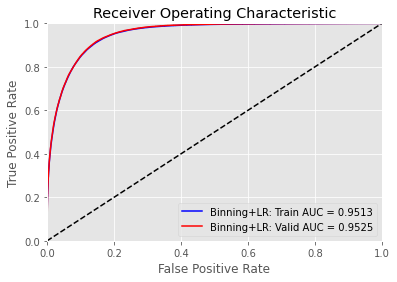

In [38]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_data['predict_proba'])
optimal_idx = np.argmax(true_positive_rate - false_positive_rate)
optimal_threshold = thresholds[optimal_idx]
auc_score = metrics.auc(false_positive_rate, true_positive_rate)
print("Train Threshold value is:", optimal_threshold)

false_positive_rate1, true_positive_rate1, thresholds = metrics.roc_curve(y_valid, valid_data['predict_proba'])
optimal_idx = np.argmax(true_positive_rate1 - false_positive_rate1)
optimal_threshold1 = thresholds[optimal_idx]
auc_score1 = metrics.auc(false_positive_rate1, true_positive_rate1)
print("Valid Threshold value is:", optimal_threshold1)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='Binning+LR: Train AUC = {0:.4f}'.format(auc_score))
plt.plot(false_positive_rate1, true_positive_rate1, 'r', label='Binning+LR: Valid AUC = {0:.4f}'.format(auc_score1))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
train_data['predict'] = (train_data['predict_proba'] > optimal_threshold).astype(int)
valid_data['predict'] = (valid_data['predict_proba'] > optimal_threshold).astype(int)

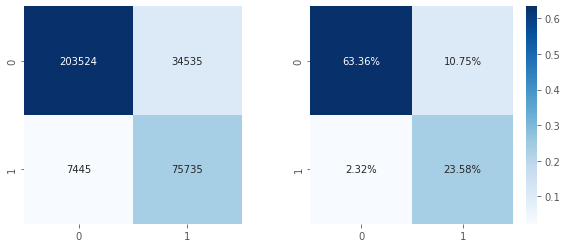

In [40]:
conf_mat = metrics.confusion_matrix(train_data['target'], train_data['predict'])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax1)
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues', ax=ax2)
plt.show()

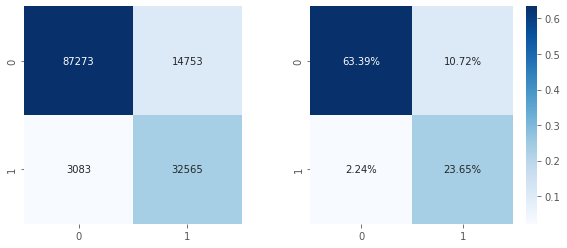

In [41]:
conf_mat = metrics.confusion_matrix(valid_data['target'], valid_data['predict'])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax1)
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues', ax=ax2)
plt.show()

In [42]:
print(metrics.classification_report(train_data['target'], train_data['predict'], labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.96      0.85      0.91    238059
           1       0.69      0.91      0.78     83180

    accuracy                           0.87    321239
   macro avg       0.83      0.88      0.84    321239
weighted avg       0.89      0.87      0.87    321239



In [43]:
print(metrics.classification_report(valid_data['target'], valid_data['predict'], labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91    102026
           1       0.69      0.91      0.79     35648

    accuracy                           0.87    137674
   macro avg       0.83      0.88      0.85    137674
weighted avg       0.89      0.87      0.88    137674



## **<span style="color:#F7B2B0;">Scores</span>**

In [44]:
train_data['score'] = scorecard.score(X_train)
valid_data['score'] = scorecard.score(X_valid)

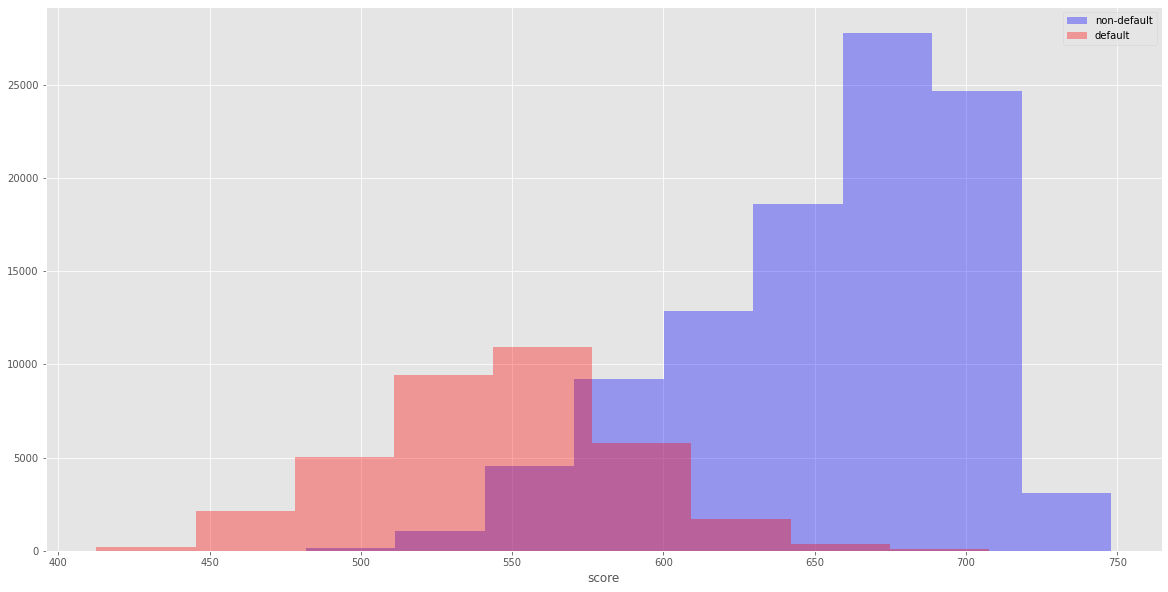

In [45]:
y_test = valid_data['target']
score = valid_data['score']

mask = y_test == 0

fig, ax = plt.subplots(figsize=(20,10))
plt.hist(score[mask], label="non-default", color="b", alpha=0.35)
plt.hist(score[~mask], label="default", color="r", alpha=0.35)
plt.xlabel("score")
plt.legend()
plt.show()

- we can observe that default vs non-default score distribution
- some overlap between 550 to 650
- overall well seperated 

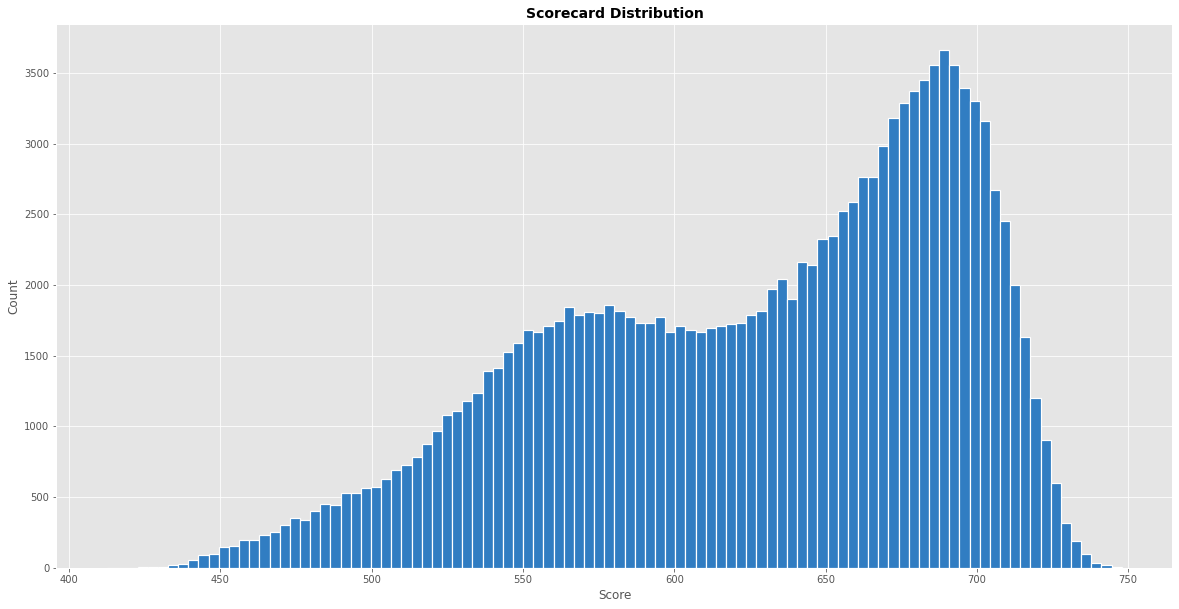

In [46]:
# Plot Distribution of Scores
plt.figure(figsize=(20,10))

plt.hist(score,
         bins=100,
         edgecolor='white',
         color = '#317DC2',
         linewidth=1.2)

#plt.xlim(231,750)
plt.title('Scorecard Distribution', fontweight="bold", fontsize=14)
# plt.axvline(score.mean(), color='k', linestyle='dashed', linewidth=1.5, alpha=0.5)
# plt.text(458, 2970, 'Mean Score: 456', color='red', fontweight='bold', style='italic', fontsize=8)
plt.xlabel('Score')
plt.ylabel('Count');

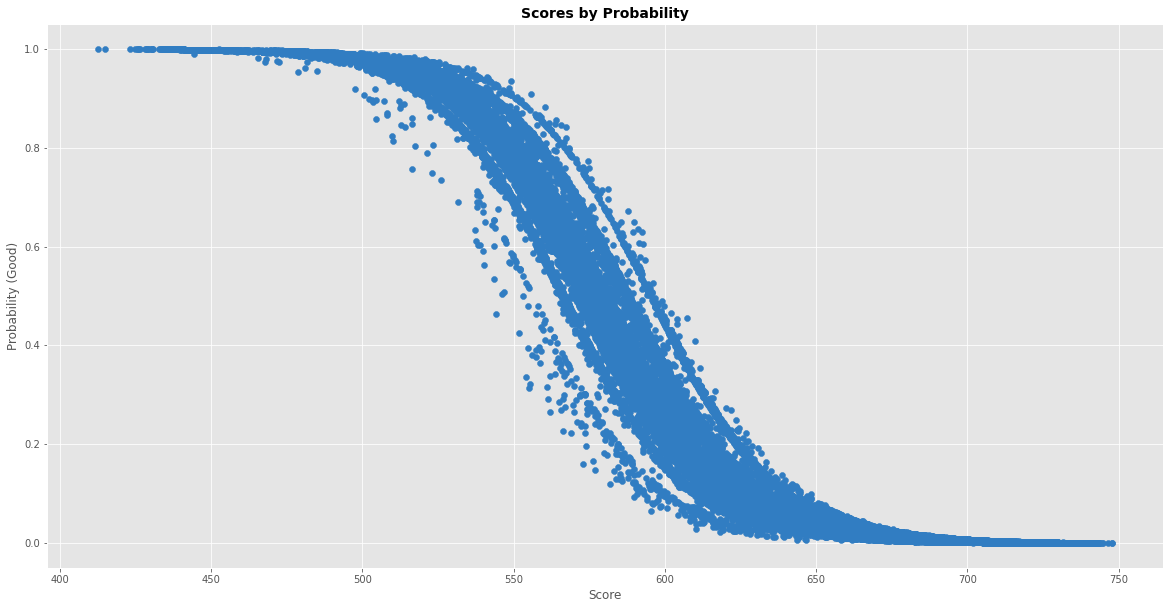

In [47]:
# Plot Scores Against Probabilities
plt.figure(figsize=(20,10))

plt.scatter(x=score,
            y=valid_data['predict_proba'],
            #data=scorecard,
            color='#317DC2')

plt.title('Scores by Probability', fontweight="bold", fontsize=14)
plt.xlabel('Score')
plt.ylabel('Probability (Good)');

# **<span style="color:#F7B2B0;">Inference</span>**

In [48]:
test_df['prediction'] = scorecard.predict_proba(X_test)[:, 1]
sub_df = test_df[['customer_ID', 'prediction']].copy()
sub_df.to_csv("submission.csv", index=False)